In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 2
commitnumber = d5931a1
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [-2, -2, 0]
ng_refs = [2, 3, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 300
vmax = 540
vmin = 340
w_diffuse = [(1.66, 1.66), (1.8, 1.8, 1.8), (1.8, 1.66, 1.45, 1.45, 1.45, 1.45)]
wgt = [(0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6, 0.6, 0.6, 0.6)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

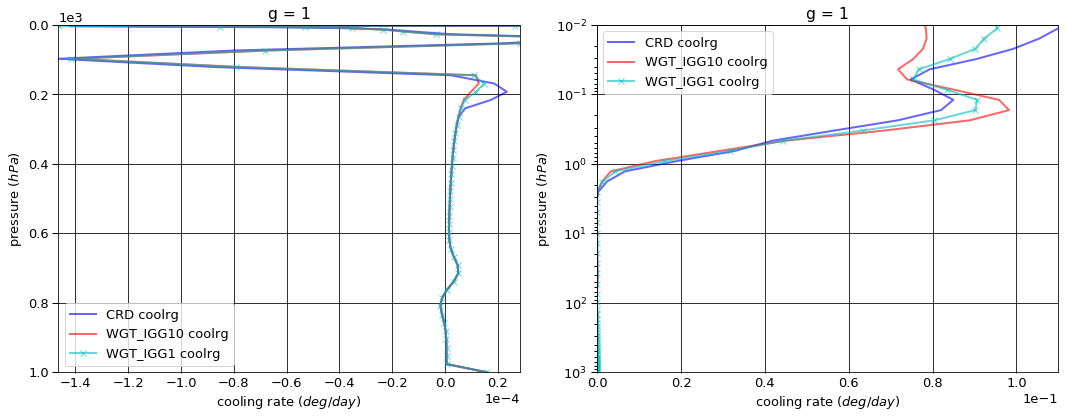

# Figure: cooling rate g-group 2

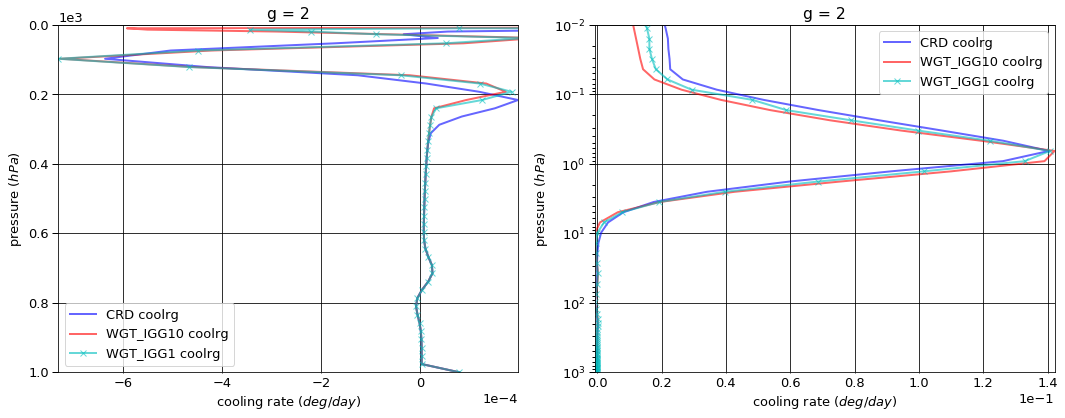

# Figure: cooling rate g-group 3

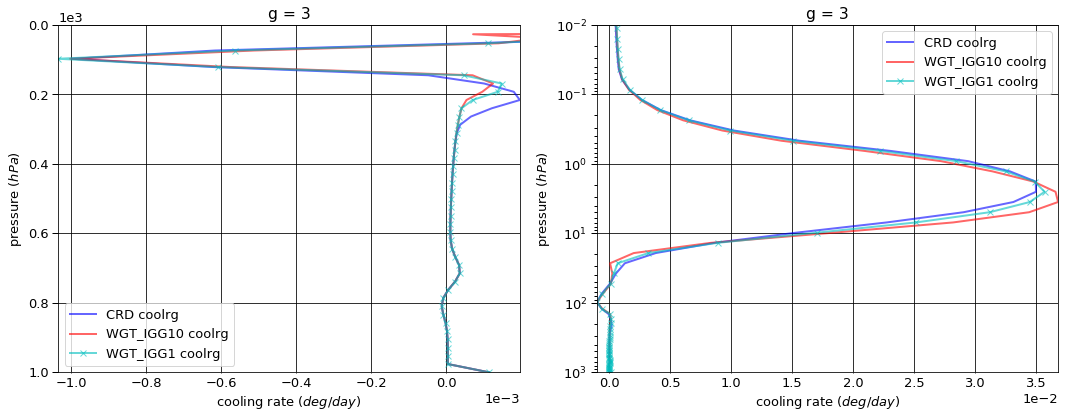

# Figure: cooling rate g-group 4

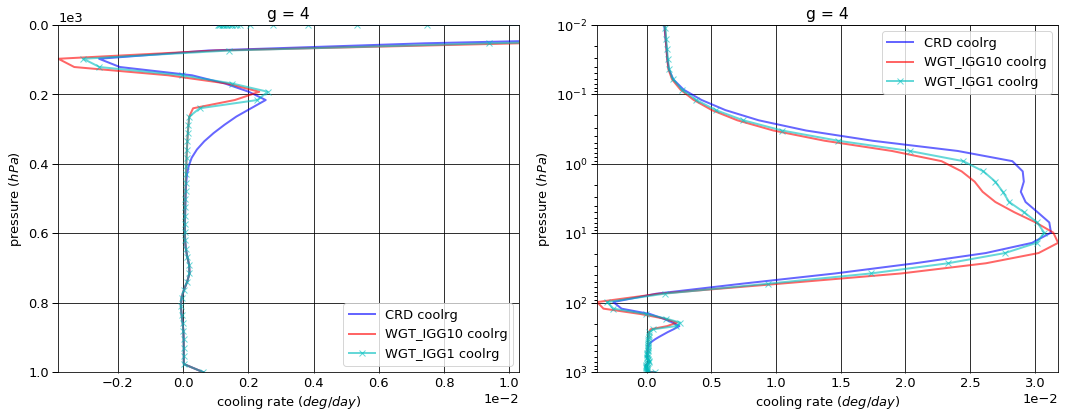

# Figure: cooling rate g-group 5

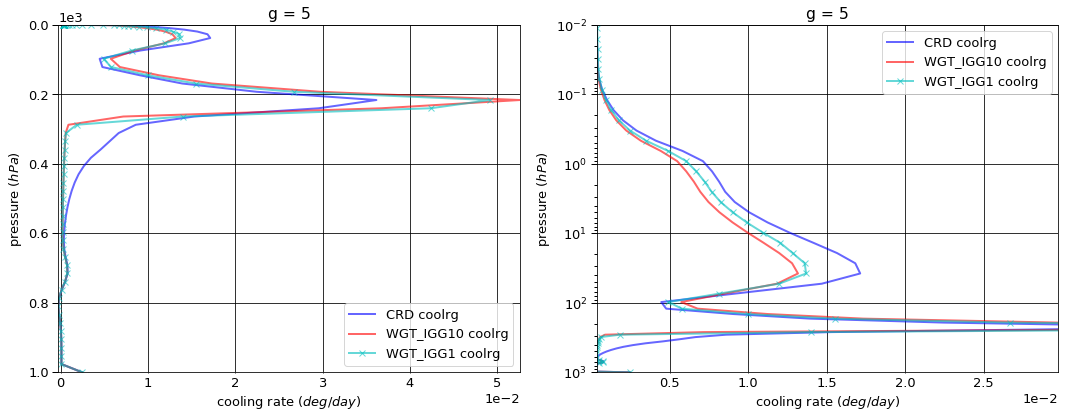

# Figure: cooling rate g-group 6

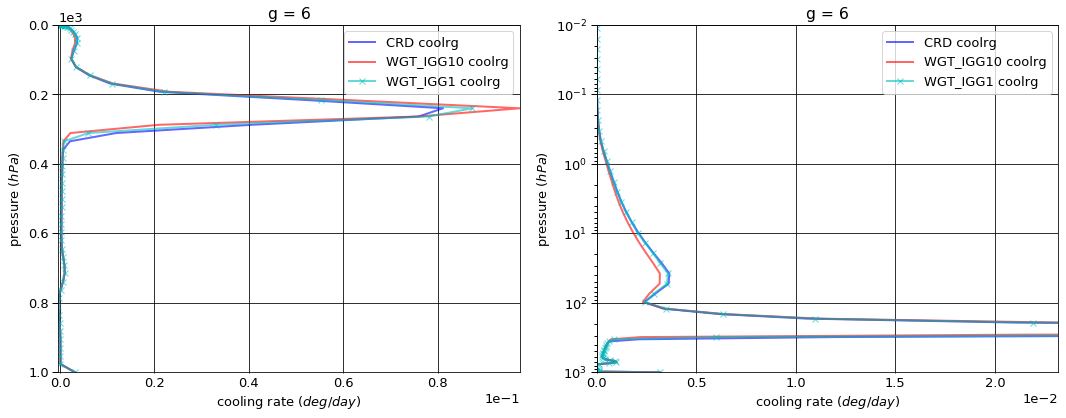

# Figure: cooling rate g-group 7

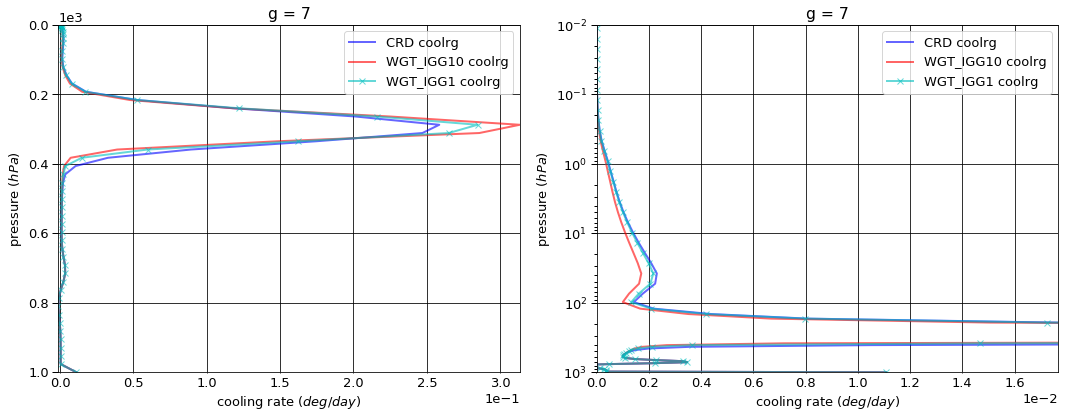

# Figure: cooling rate g-group 8

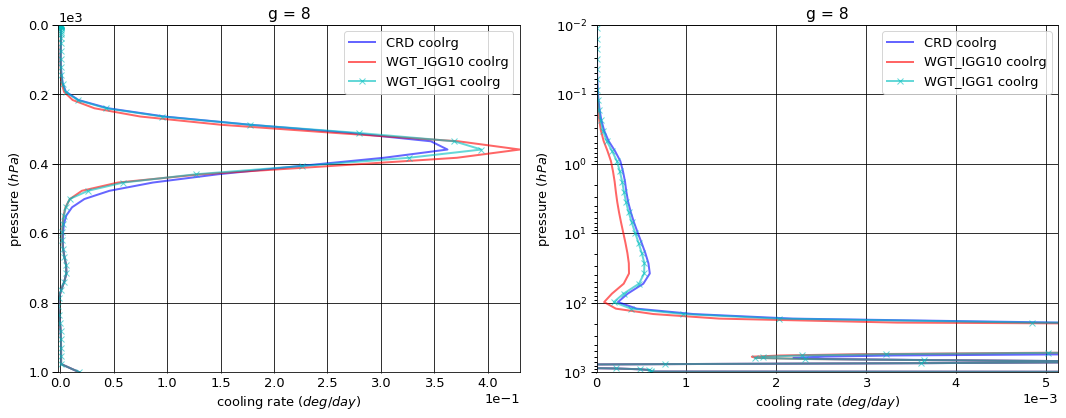

# Figure: cooling rate g-group 9

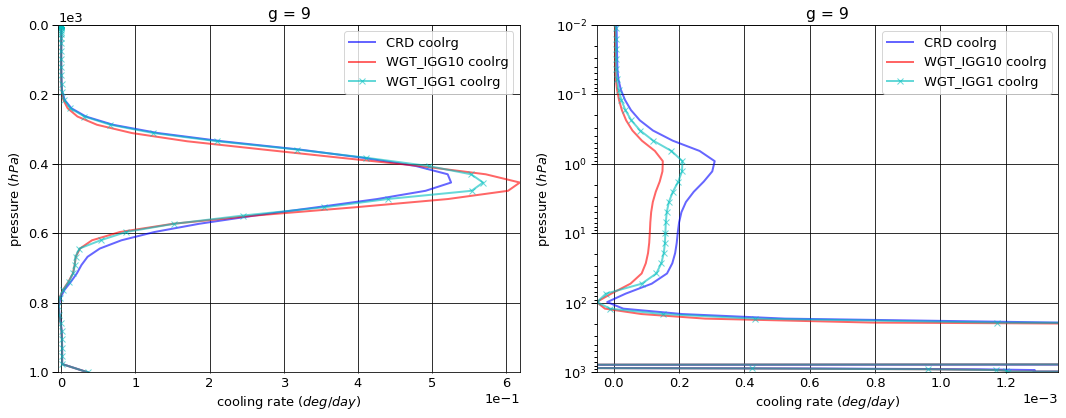

# Figure: cooling rate g-group 10

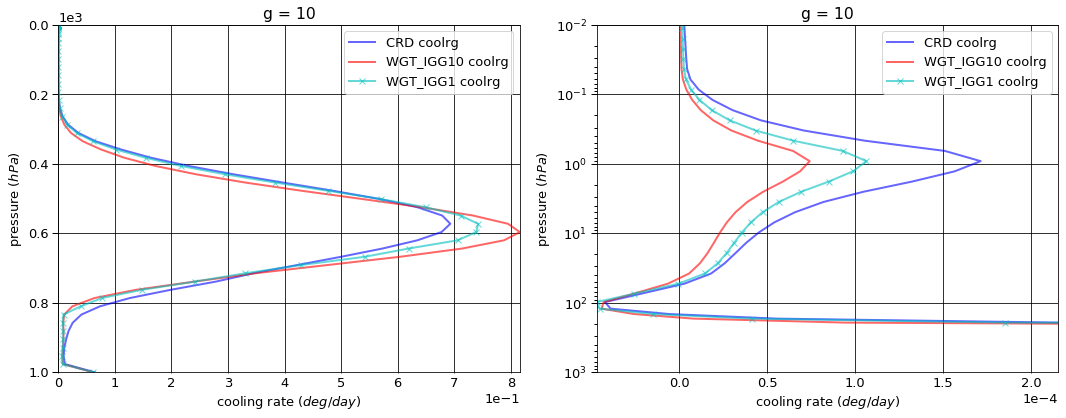

# Figure: cooling rate g-group 11

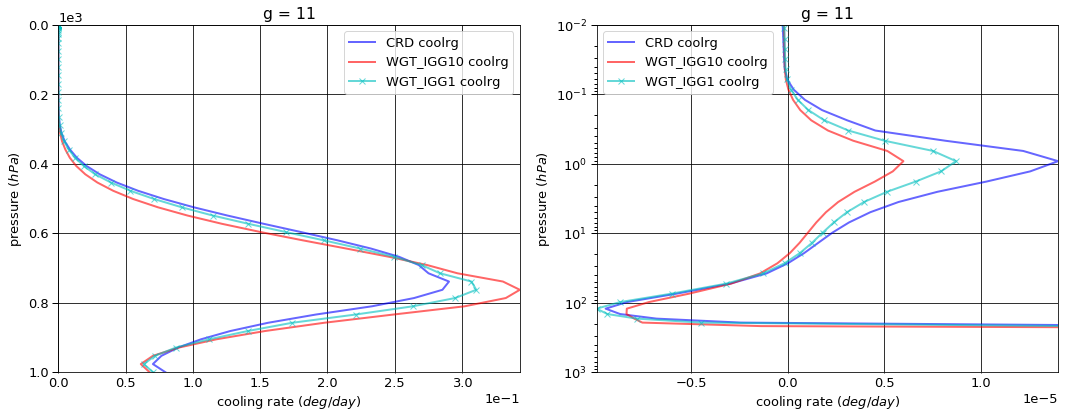

# Figure: cooling rate g-group total

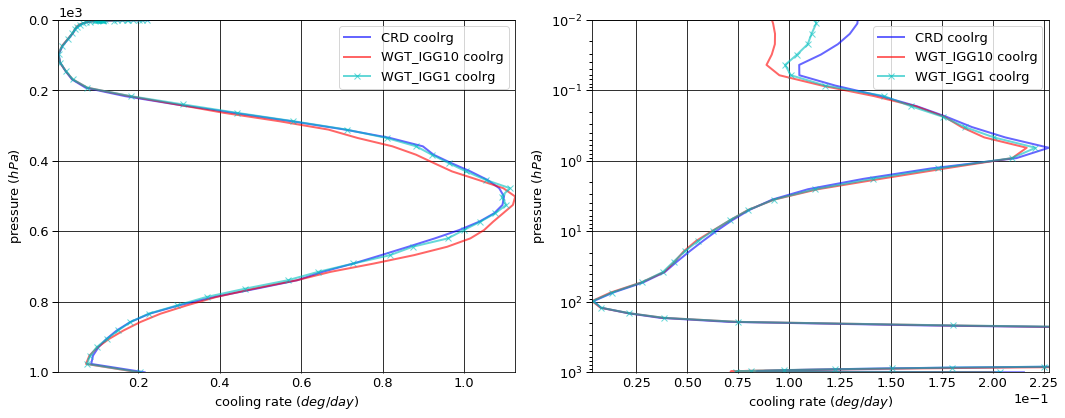

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005838   0.000000  -0.005838
   1013.0   76     -0.009730   0.009686  -0.000044
2  0.0      1      -0.029554   0.000000  -0.029554
   1013.0   76     -0.044436   0.044218  -0.000218
3  0.0      1      -0.039669   0.000000  -0.039669
   1013.0   76     -0.067355   0.067041  -0.000314
4  0.0      1      -0.170373   0.000000  -0.170373
   1013.0   76     -0.365879   0.364146  -0.001733
5  0.0      1      -0.650597   0.000000  -0.650597
   1013.0   76     -1.429126   1.422342  -0.006784
6  0.0      1      -0.937330   0.000000  -0.937330
   1013.0   76     -1.885778   1.876986  -0.008792
7  0.0      1      -3.584203   0.000000  -3.584203
   1013.0   76     -6.479185   6.448499  -0.030685
8  0.0      1      -6.301506   0.000000  -6.301506
   1013.0   76    -10.308642  10.259287  -0.049355
9  0.0      1     -13.696822   0.000000 -13.696822
   1013.0   76    -20.135346  20.036259  -0.099088
10 0.0      1     -23.926835   0.000000 -23.926835
   1013.0   76    -31.540371  31.351787  -0.188583
11 0.0      1     -11.851035   0.000000 -11.851035
   1013.0   76    -14.209382  13.706767  -0.502614


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005745   0.000000  -0.005745
   1013.0   76     -0.009730   0.009686  -0.000044
2  0.0      1      -0.030658   0.000000  -0.030658
   1013.0   76     -0.044436   0.044218  -0.000218
3  0.0      1      -0.040546   0.000000  -0.040546
   1013.0   76     -0.067355   0.067041  -0.000314
4  0.0      1      -0.164087   0.000000  -0.164087
   1013.0   76     -0.365879   0.364146  -0.001733
5  0.0      1      -0.616414   0.000000  -0.616414
   1013.0   76     -1.429126   1.422345  -0.006781
6  0.0      1      -0.925104   0.000000  -0.925104
   1013.0   76     -1.885778   1.876986  -0.008792
7  0.0      1      -3.561174   0.000000  -3.561174
   1013.0   76     -6.479185   6.448499  -0.030685
8  0.0      1      -6.314577   0.000000  -6.314577
   1013.0   76    -10.308642  10.259287  -0.049355
9  0.0      1     -13.745989   0.000000 -13.745989
   1013.0   76    -20.135346  20.036381  -0.098966
10 0.0      1     -24.096195   0.000000 -24.096195
   1013.0   76    -31.540371  31.367944  -0.172427
11 0.0      1     -11.980828   0.000000 -11.980828
   1013.0   76    -14.209382  13.905858  -0.303524


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005769   0.000000  -0.005769
   1013.0   76     -0.009730   0.009686  -0.000044
2  0.0      1      -0.030302   0.000000  -0.030302
   1013.0   76     -0.044436   0.044218  -0.000218
3  0.0      1      -0.040142   0.000000  -0.040142
   1013.0   76     -0.067355   0.067041  -0.000314
4  0.0      1      -0.163492   0.000000  -0.163492
   1013.0   76     -0.365879   0.364146  -0.001733
5  0.0      1      -0.625404   0.000000  -0.625404
   1013.0   76     -1.429126   1.422345  -0.006781
6  0.0      1      -0.931035   0.000000  -0.931035
   1013.0   76     -1.885778   1.876986  -0.008792
7  0.0      1      -3.561859   0.000000  -3.561859
   1013.0   76     -6.479185   6.448499  -0.030685
8  0.0      1      -6.266210   0.000000  -6.266210
   1013.0   76    -10.308642  10.259287  -0.049355
9  0.0      1     -13.629291   0.000000 -13.629291
   1013.0   76    -20.135346  20.036381  -0.098965
10 0.0      1     -23.871899   0.000000 -23.871899
   1013.0   76    -31.540371  31.365484  -0.174887
11 0.0      1     -11.868579   0.000000 -11.868579
   1013.0   76    -14.209382  13.878129  -0.331253


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      9.306240e-05  0.000000e+00  9.306240e-05
   1013.0   76     0.000000e+00  0.000000e+00 -6.776264e-21
2  0.0      1     -1.103239e-03  0.000000e+00 -1.103239e-03
   1013.0   76     0.000000e+00  0.000000e+00 -2.710505e-20
3  0.0      1     -8.769530e-04  0.000000e+00 -8.769530e-04
   1013.0   76     0.000000e+00  0.000000e+00 -5.421011e-20
4  0.0      1      6.285990e-03  0.000000e+00  6.285990e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1      3.418267e-02  0.000000e+00  3.418267e-02
   1013.0   76     0.000000e+00  3.300000e-06  3.375300e-06
6  0.0      1      1.222575e-02  0.000000e+00  1.222575e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      2.302840e-02  0.000000e+00  2.302840e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1     -1.307160e-02  0.000000e+00 -1.307160e-02
   1013.0   76    -1.776357e-15  1.776357e-15  0.000000e+00
9  0.0      1     -4.916700e-02  0.000000e+00 -4.916700e-02
   1013.0   76     0.000000e+00  1.220000e-04  1.224030e-04
10 0.0      1     -1.693600e-01  0.000000e+00 -1.693600e-01
   1013.0   76     0.000000e+00  1.615700e-02  1.615605e-02
11 0.0      1     -1.297930e-01  0.000000e+00 -1.297930e-01
   1013.0   76     0.000000e+00  1.990910e-01  1.990906e-01


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      6.863040e-05  0.000000e+00  6.863040e-05
   1013.0   76     0.000000e+00  0.000000e+00 -6.776264e-21
2  0.0      1     -7.478510e-04  0.000000e+00 -7.478510e-04
   1013.0   76     0.000000e+00  0.000000e+00 -2.710505e-20
3  0.0      1     -4.734420e-04  0.000000e+00 -4.734420e-04
   1013.0   76     0.000000e+00  0.000000e+00 -5.421011e-20
4  0.0      1      6.880950e-03  0.000000e+00  6.880950e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5  0.0      1      2.519335e-02  0.000000e+00  2.519335e-02
   1013.0   76     0.000000e+00  3.300000e-06  3.375300e-06
6  0.0      1      6.294060e-03  0.000000e+00  6.294060e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      2.234370e-02  0.000000e+00  2.234370e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      3.529600e-02  0.000000e+00  3.529600e-02
   1013.0   76    -1.776357e-15  1.776357e-15  0.000000e+00
9  0.0      1      6.753100e-02  0.000000e+00  6.753100e-02
   1013.0   76     0.000000e+00  1.220000e-04  1.224210e-04
10 0.0      1      5.493600e-02  0.000000e+00  5.493600e-02
   1013.0   76     0.000000e+00  1.369700e-02  1.369620e-02
11 0.0      1     -1.754400e-02  0.000000e+00 -1.754400e-02
   1013.0   76     0.000000e+00  1.713620e-01  1.713617e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.035447e-01
   1001.112500 75     1.582630e-05
2  0.000312    1      1.362085e-02
   1001.112500 75     7.870260e-05
3  0.000312    1      3.020477e-04
   1001.112500 75     1.131651e-04
4  0.000312    1      9.420417e-04
   1001.112500 75     6.252163e-04
5  0.000312    1      2.419090e-04
   1001.112500 75     2.447130e-03
6  0.000312    1      1.427214e-06
   1001.112500 75     3.172471e-03
7  0.000312    1      4.321428e-06
   1001.112500 75     1.107049e-02
8  0.000312    1      5.058242e-06
   1001.112500 75     1.780349e-02
9  0.000312    1      5.195111e-06
   1001.112500 75     3.573412e-02
10 0.000312    1      4.835443e-07
   1001.112500 75     6.447894e-02
11 0.000312    1     -4.110630e-07
   1001.112500 75     7.967932e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      6.298901e-02
   1001.112500 75     1.582630e-05
2  0.000312    1      6.105135e-03
   1001.112500 75     7.870260e-05
3  0.000312    1      3.758086e-04
   1001.112500 75     1.131651e-04
4  0.000312    1      1.062780e-03
   1001.112500 75     6.252163e-04
5  0.000312    1      2.702451e-04
   1001.112500 75     2.446242e-03
6  0.000312    1      1.278508e-06
   1001.112500 75     3.172471e-03
7  0.000312    1      3.388977e-06
   1001.112500 75     1.107049e-02
8  0.000312    1      2.484811e-06
   1001.112500 75     1.780349e-02
9  0.000312    1      2.065378e-06
   1001.112500 75     3.568917e-02
10 0.000312    1     -4.289312e-07
   1001.112500 75     6.170473e-02
11 0.000312    1     -2.537082e-07
   1001.112500 75     6.787994e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      8.315959e-02
   1001.112500 75     1.582630e-05
2  0.000312    1      9.363792e-03
   1001.112500 75     7.870260e-05
3  0.000312    1      3.737684e-04
   1001.112500 75     1.131651e-04
4  0.000312    1      1.080442e-03
   1001.112500 75     6.252163e-04
5  0.000312    1      2.985621e-04
   1001.112500 75     2.446242e-03
6  0.000312    1      1.482480e-06
   1001.112500 75     3.172471e-03
7  0.000312    1      4.390042e-06
   1001.112500 75     1.107049e-02
8  0.000312    1      3.858711e-06
   1001.112500 75     1.780349e-02
9  0.000312    1      3.385194e-06
   1001.112500 75     3.568914e-02
10 0.000312    1      1.710921e-07
   1001.112500 75     6.207675e-02
11 0.000312    1     -2.718165e-07
   1001.112500 75     7.039221e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -4.055570e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -7.515713e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      7.376092e-05
   1001.112500 75    -1.355253e-20
4  0.000312    1      1.207386e-04
   1001.112500 75     0.000000e+00
5  0.000312    1      2.833609e-05
   1001.112500 75    -8.882000e-07
6  0.000312    1     -1.487060e-07
   1001.112500 75     0.000000e+00
7  0.000312    1     -9.324510e-07
   1001.112500 75     0.000000e+00
8  0.000312    1     -2.573431e-06
   1001.112500 75     0.000000e+00
9  0.000312    1     -3.129733e-06
   1001.112500 75    -4.495100e-05
10 0.000312    1     -9.124754e-07
   1001.112500 75    -2.774214e-03
11 0.000312    1      1.573548e-07
   1001.112500 75    -1.179938e-02


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.038512e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.257056e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      7.172076e-05
   1001.112500 75    -1.355253e-20
4  0.000312    1      1.384003e-04
   1001.112500 75     0.000000e+00
5  0.000312    1      5.665307e-05
   1001.112500 75    -8.882000e-07
6  0.000312    1      5.526600e-08
   1001.112500 75     0.000000e+00
7  0.000312    1      6.861460e-08
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.199530e-06
   1001.112500 75     0.000000e+00
9  0.000312    1     -1.809917e-06
   1001.112500 75    -4.497600e-05
10 0.000312    1     -3.124521e-07
   1001.112500 75    -2.402187e-03
11 0.000312    1      1.392465e-07
   1001.112500 75    -9.287110e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.193761,0.000000,-61.193761
1013.0,76,-86.475231,85.587019,-0.888211



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.481317,0.000000,-61.481317
1013.0,76,-86.475231,85.802393,-0.672839



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.993982,0.000000,-60.993982
1013.0,76,-86.475231,85.772204,-0.703027



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.875559e-01,0.000000,-0.287556
1013.0,76,-1.421085e-14,0.215373,0.215372



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.997784e-01,0.000000,0.199778
1013.0,76,-1.421085e-14,0.185184,0.185184


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.118668
1001.112500,75,0.215219



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.070812
1001.112500,75,0.200599



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.094289
1001.112500,75,0.203484



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.047856
1001.112500,75,-0.014619



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.024378
1001.112500,75,-0.011735


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000119
2,0.000525,0.000521
3,0.000840,0.000810
4,0.004490,0.004364
5,0.017520,0.017032
6,0.023475,0.022653
7,0.079385,0.077276
8,0.125500,0.122349
9,0.238215,0.235985


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.013979e-17
2,7.376594e-19
3,4.606445e-19
4,3.437534e-20
5,2.565240e-21
6,2.180272e-20
7,3.897251e-21
8,6.966363e-22
9,1.245242e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.013979e-17,NaN,0.000125,0.000119,0.000125,0.000119,1.0
2,7.376594e-19,0.072749,0.000525,0.000521,0.000650,0.000640,1.0
3,4.606445e-19,0.624468,0.000840,0.000810,0.001490,0.001449,10.0
4,3.437534e-20,0.074624,0.004490,0.004364,0.005980,0.005813,10.0
5,2.565240e-21,0.074624,0.017520,0.017032,0.023500,0.022845,10.0
6,2.180272e-20,8.499291,0.023475,0.022653,0.046975,0.045498,500.0
7,3.897251e-21,0.178751,0.079385,0.077276,0.126360,0.122774,500.0
8,6.966363e-22,0.178751,0.125500,0.122349,0.251860,0.245123,500.0
9,1.245242e-22,0.178751,0.238215,0.235985,0.490075,0.481108,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
